In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pickle
from IPython.display import clear_output

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

sns.set_context("talk")
sns.set_style("white")


In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
mm = mydict['m']
model_name = mydict['model_name']

# link to desired concept of truth
truth = truth[['run', 'pid', 'correct', 'hallucinated']]

In [3]:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def assessme(y_true, y_pred, printme=False):
    met = {}
    met['mae'] = mean_absolute_error(y_true, y_pred)
    met['mse'] = mean_squared_error(y_true, y_pred)
    met['rmse'] = np.sqrt(met['mse'])
    met['r2'] = r2_score(y_true, y_pred)
    n, k = len(y_true), 1
    met['adj_r2'] = 1 - (1 - met['r2']) * (n - 1) / (n - k - 1)
    if printme:
        print(f" MAE: {met['mae']}\n MSE: {met['mse']}\n RMSE: {met['rmse']}\n R²: {met['r2']}\n Adjusted R²: {met['adj_r2']}")
    return met

### semantic uncertainty (rao_s)

In [5]:
mm.run.max()

9

In [6]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [7]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

63

In [8]:
%%time

# take generated 
mmg = mm[mm.segment=='generated']

# expand logitlens kl (for generated only)
df_logitlens_kl_expanded = mmg['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded.shape[1])]

mmg = pd.concat([mmg.drop(columns=['logitlens_kl', 'logitlens_iou']),
                 df_logitlens_kl_expanded], 
                 axis=1)

mmg.shape

CPU times: user 44.9 s, sys: 961 ms, total: 45.8 s
Wall time: 45.8 s


(909967, 49)

In [9]:
%%time

# take postilla
mmp = mm[mm.segment=='postilla']

# expand logitlens kl (for generated only)
df_logitlens_kl_expanded_postilla = mmp['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded_postilla.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded_postilla.shape[1])]

mmp = pd.concat([mmp.drop(columns=['logitlens_kl', 'logitlens_iou']),
                 df_logitlens_kl_expanded_postilla], 
                 axis=1)

mmp.shape

CPU times: user 3.75 s, sys: 88.9 ms, total: 3.84 s
Wall time: 3.83 s


(90120, 49)

In [10]:
%%time

# multiply fishes

runs = pd.DataFrame({"run": range(10)}) 
mmp = mmp.drop(columns=['run']) # only run 0
mmp_e = runs.merge(mmp, how="cross")

mmp_e.shape[0] == 10 * mmp.shape[0]

CPU times: user 83.1 ms, sys: 66.7 ms, total: 150 ms
Wall time: 150 ms


True

In [11]:
# reconstructed vectors for postilla and generated (half a GB)
mmg = pd.concat([mmg, mmp_e], axis=0).sort_values(["run", "pid", "tok"])

In [12]:
### BEWARE: here we move first generated token in postilla as a FALLBACK (waiting to regenerate files)
### motivated by observability
postilla_max = mmg[mmg.segment=='postilla'].tokzero.max()
print(postilla_max)

# NO MORE
#mask = (mmg.segment=='generated') & (mmg.tokzero==0)
#mmg.loc[mask, 'tokzero'] = postilla_max + 1
#mmg.loc[mask, 'segment'] = 'postilla'


59


In [13]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

In [14]:
target = 'pe_rao_trans_s_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

In [15]:
ds

,run,pid,true_ent_0,true_ent_1,true_ent_2,true_ent_3,true_ent_4,true_ent_5,true_ent_6,true_ent_7,true_ent_8,true_ent_9,maxp_0,maxp_1,maxp_2,maxp_3,maxp_4,maxp_5,maxp_6,maxp_7,maxp_8,maxp_9,correct,hallucinated,pe_rao_trans_s_norm,correct_mean
0,0,0,1.611816,0.976463,0.005994,0.006354,0.000015,0.791350,0.005734,0.003063,0.595787,0.000488,0.738251,0.821538,0.999493,0.999514,0.999999,0.739252,0.999544,0.999773,0.834691,0.999967,False,True,0.657497,0.0
1,1,0,1.611816,3.233433,0.002801,0.003736,0.000296,1.307779,2.572681,2.845631,4.762380,2.118876,0.738251,0.207016,0.999760,0.999731,0.999977,0.621661,0.420527,0.283257,0.205636,0.373746,False,True,0.657497,0.0
2,2,0,1.611816,3.233433,0.003670,0.790100,0.006206,0.000593,0.000003,0.026185,0.004014,0.000104,0.738251,0.207016,0.999736,0.730506,0.999421,0.999952,1.000000,0.997040,0.999678,0.999992,False,True,0.657497,0.0
3,3,0,1.611816,3.233433,0.279819,0.007267,0.003757,0.000071,0.957262,0.079718,0.003150,0.001556,0.738251,0.207016,0.941740,0.999341,0.999737,0.999995,0.527939,0.991058,0.999765,0.999890,False,True,0.657497,0.0
4,4,0,1.611816,3.233433,2.840998,0.850192,1.881267,2.952285,3.307381,2.305814,1.039491,2.729675,0.738251,0.207016,0.338126,0.577232,0.473248,0.224993,0.262416,0.330525,0.794898,0.341138,False,True,0.657497,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14945,5,1800,1.088859,1.717199,0.895586,0.000040,0.575412,0.000149,0.000013,0.001067,0.000201,0.000043,0.757150,0.547844,0.807772,0.999998,0.773760,0.999990,0.999999,0.999918,0.999985,0.999997,True,False,0.536787,0.0
14946,6,1800,1.088859,1.717199,0.895586,0.000040,0.575412,0.000149,0.000013,0.001067,0.000201,0.000043,0.757150,0.547844,0.807772,0.999998,0.773760,0.999990,0.999999,0.999918,0.999985,0.999997,True,False,0.536787,0.0
14947,7,1800,1.088859,1.717199,0.001979,0.000019,0.723795,0.000164,0.000005,0.000852,0.000220,0.000025,0.757150,0.547844,0.999834,0.999999,0.560203,0.999989,1.000000,0.999936,0.999984,0.999998,True,False,0.536787,0.0
14948,8,1800,1.088859,0.065319,0.000033,0.780563,0.000314,0.000024,0.002744,0.000419,0.000140,0.086804,0.757150,0.993567,0.999998,0.554998,0.999979,0.999999,0.999773,0.999968,0.999989,0.989596,True,False,0.536787,0.0


In [16]:
ds.correct.value_counts()

correct
False    10301
True      4649
Name: count, dtype: int64

In [17]:
# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.dropna().drop_duplicates(ds.columns[1:-3])

In [18]:
y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

In [19]:
X.loc[:,X.nunique()!=1].shape

(7248, 20)

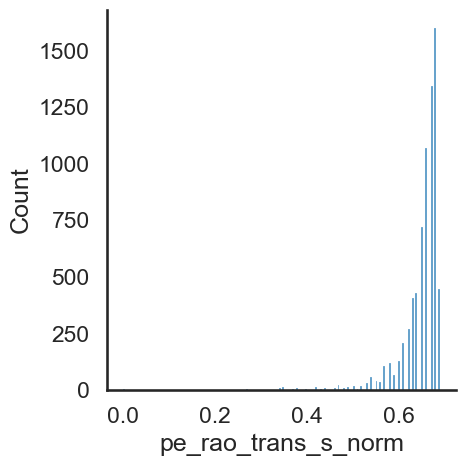

In [20]:
sns.displot(y)

In [21]:
X.isnull().sum().sum() == 0

True

In [22]:
# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [23]:
X_res.isnull().sum().sum() == 0

True

### beginning of generation, entropy

In [24]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 7.88 s, sys: 3.28 s, total: 11.2 s
Wall time: 1.53 s


In [26]:
palette

{0.0: '#b40426',
 0.1: '#b70d28',
 0.2: '#c32e31',
 0.6: '#f5c0a7',
 0.3: '#d44e41',
 0.4: '#e57058'}

In [30]:
correct_mean_thr.value_counts()

correct_mean
False    7246
True        2
Name: count, dtype: int64

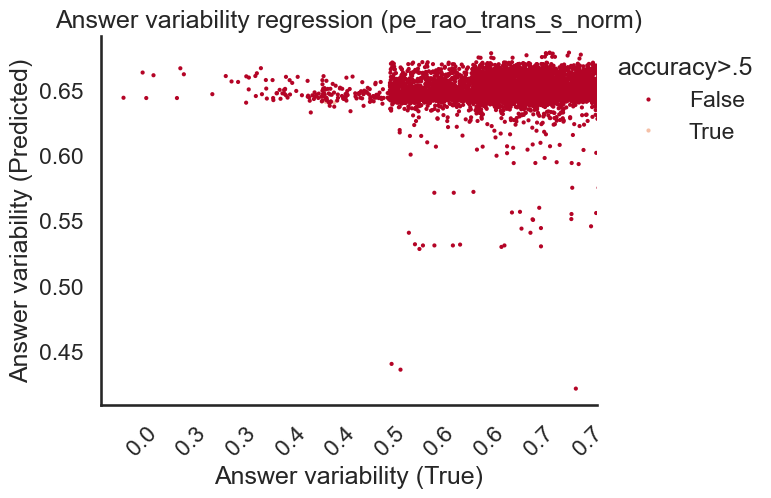

In [31]:
import matplotlib.colors as mcolors

norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=1, 
                   hue=correct_mean_thr, 
                   size=3, 
                   palette = palette)
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [ ]:
palette = Bold_10.mpl_colors

ax = sns.violinplot(y=pred, x=np.round(y_res.values,0), 
                    split=True, inner="quart", width=0.8, color=palette[8]) # , log_scale=(True,False))

plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

plt.show()

In [ ]:
met = assessme(y_res.values, pred)
met

In [ ]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean_thr[pred>=thr]).sum() / (pred>=thr).sum() for thr in thresholds]

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

In [ ]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [correct_mean[pred>=thr].mean() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc mean", marker="o", color=palette[4], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[4])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

### answers entropy

In [135]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

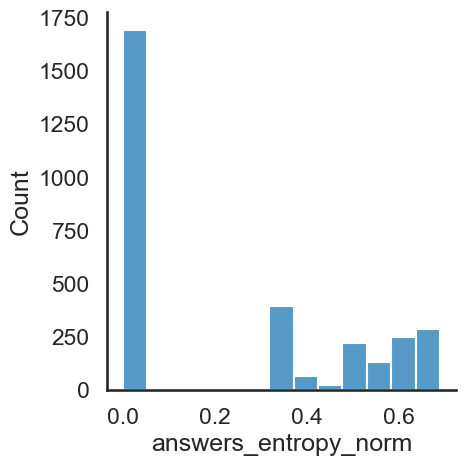

In [136]:
sns.displot(y)

In [137]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 7.05 s, sys: 813 ms, total: 7.87 s
Wall time: 1.05 s


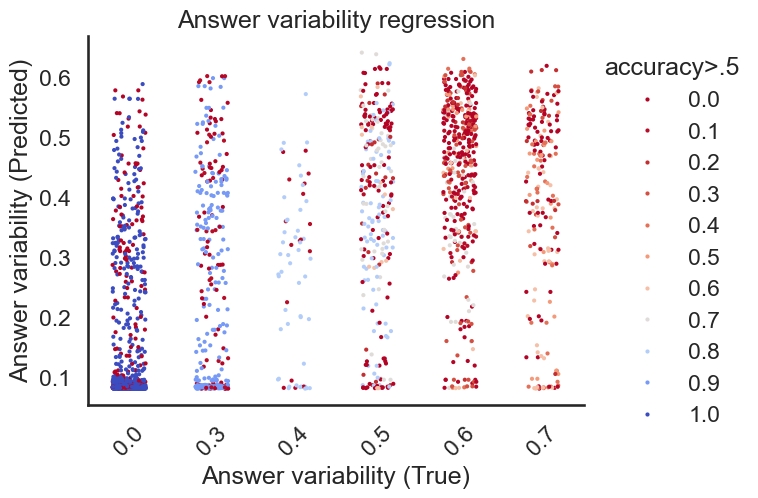

In [138]:
norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), jitter=0.2, hue=correct_mean, size=3, palette=palette) # , log_scale=(True,False))
sns.despine()

plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

#from matplotlib.ticker import MaxNLocator
#ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [139]:
met = assessme(y_res.values, pred)
met

{'mae': 0.15062869120877567,
 'mse': 0.036888215116417135,
 'rmse': 0.19206304984670303,
 'r2': 0.48367086376299173,
 'adj_r2': 0.4835019631623254}

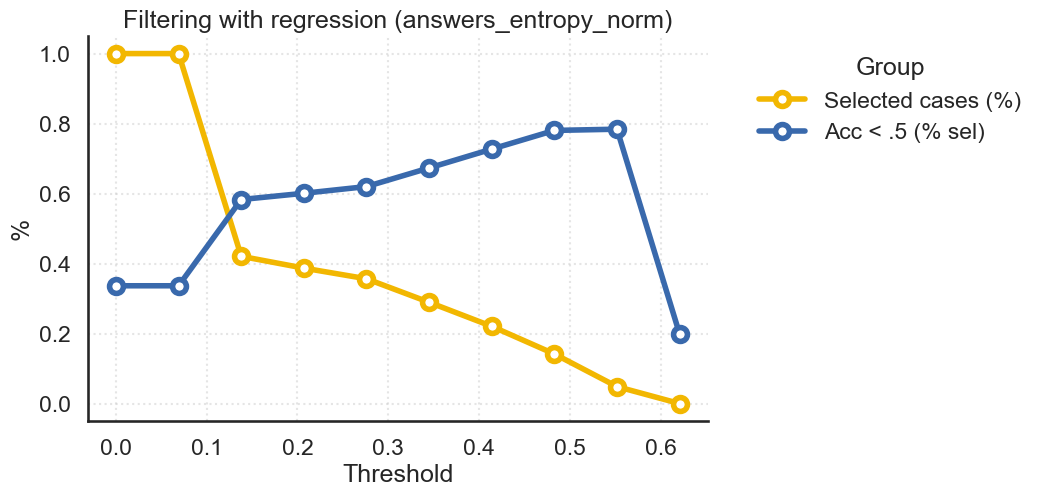

In [140]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred > thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean_thr[pred>thr]).sum() / (pred>thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

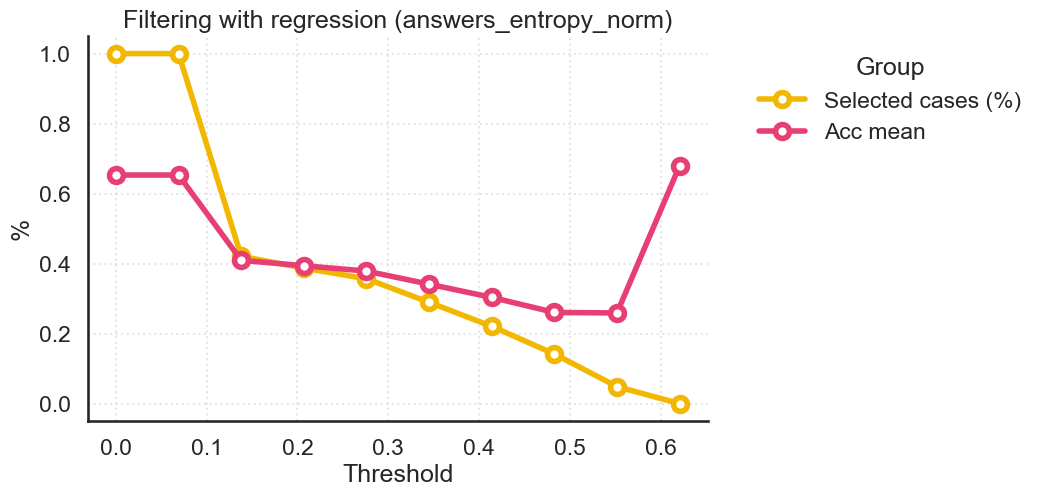

In [141]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [correct_mean[pred>=thr].mean() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc mean", marker="o", color=palette[4], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[4])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

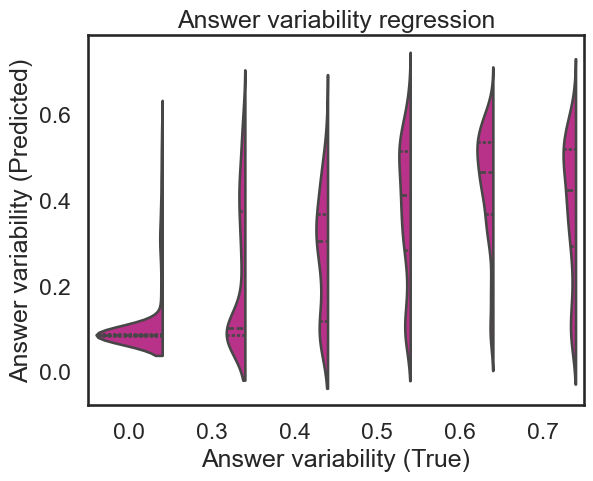

In [142]:
ax = sns.violinplot(y=pred, x=np.round(y_res.values,1), 
                    split=True, inner="quart", width=0.8, color=palette[8]) # , log_scale=(True,False))


plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

plt.show()

In [143]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

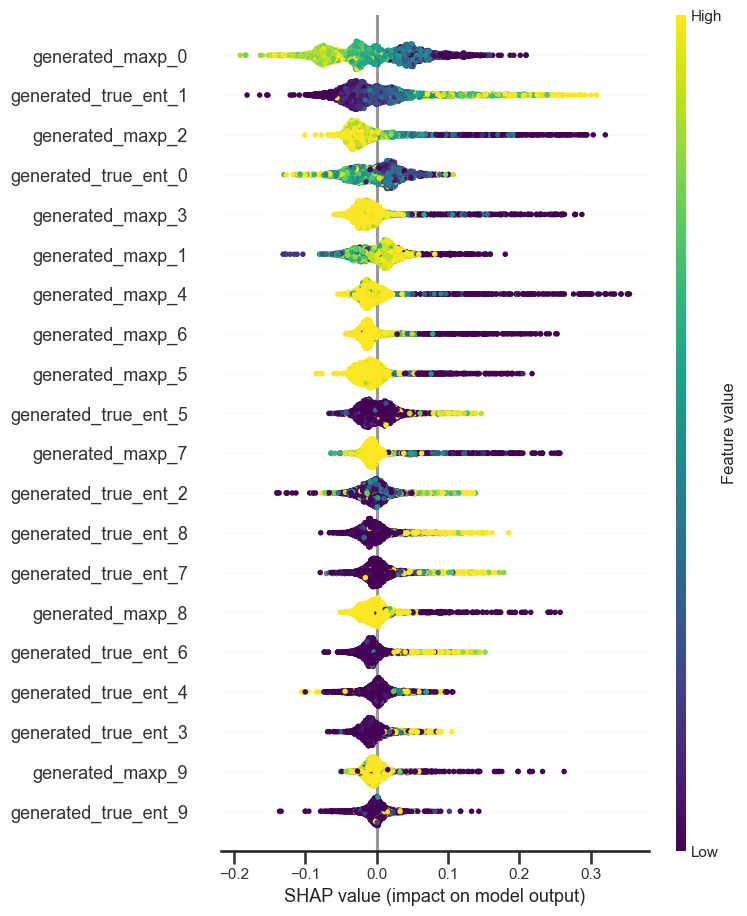

In [144]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [145]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [146]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.550555
generated_true_ent_    0.449445
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

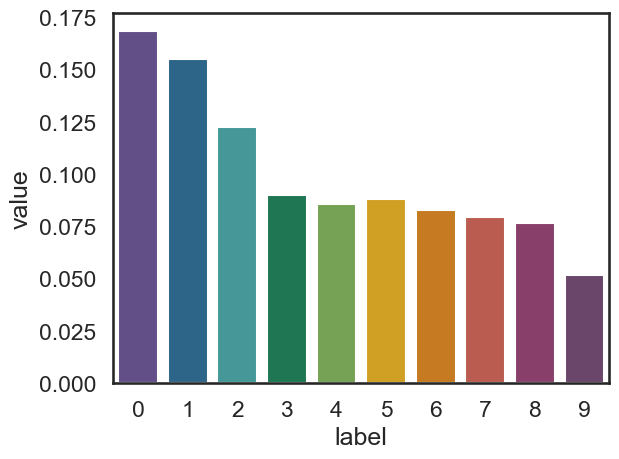

In [147]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(33.22569444444443, 0.5, 'Token index')

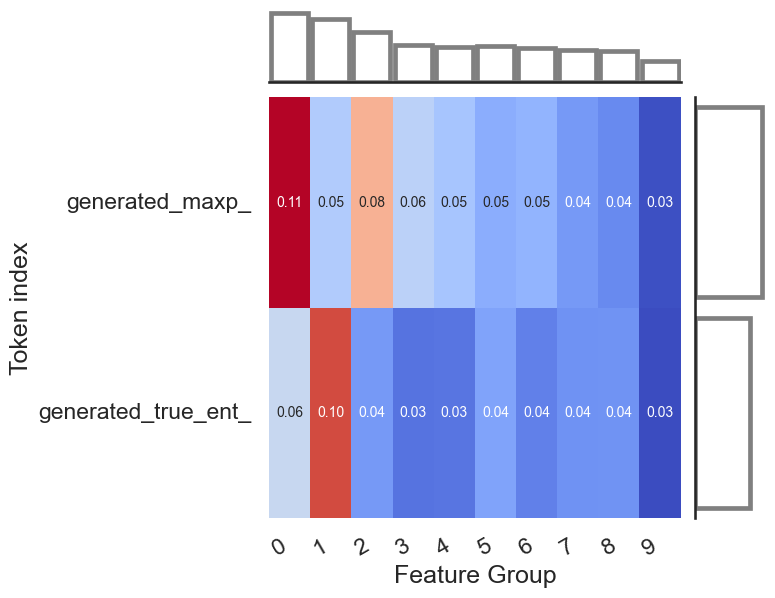

In [148]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### all features

In [149]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'pe_rao_trans_s_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [150]:
X_res.shape

(5247, 430)

In [151]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 1min 45s, sys: 3.86 s, total: 1min 49s
Wall time: 18 s


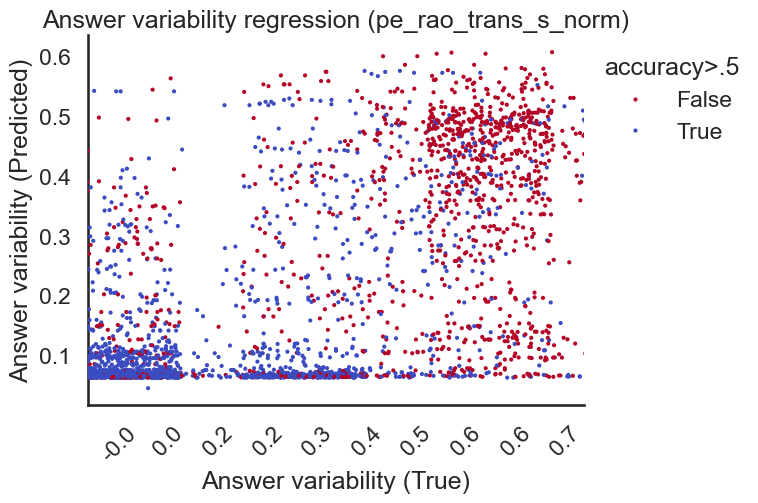

In [152]:
norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=1, 
                   hue=correct_mean, 
                   size=3, palette=palette) # , log_scale=(True,False))
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [153]:
met = assessme(y_res.values, pred)
met

{'mae': 0.13763983294347912,
 'mse': 0.032776535072863704,
 'rmse': 0.18104290947966922,
 'r2': 0.437408394309855,
 'adj_r2': 0.437301131849285}

In [154]:
%%time

import xgboost
import shap

# model = xgboost.XGBRegressor(n_estimators=100, booster='gblinear').fit(X_res, y_res)
model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

 94%|=================== | 4917/5247 [00:11<00:00]       

CPU times: user 24.2 s, sys: 1.85 s, total: 26 s
Wall time: 13.4 s


In [155]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

vals.groupby('grp').value.sum()

grp
generated_logitlens_kl_    0.736838
generated_maxp_            0.134000
generated_true_ent_        0.129162
Name: value, dtype: float64

Text(33.22569444444443, 0.5, 'Token index')

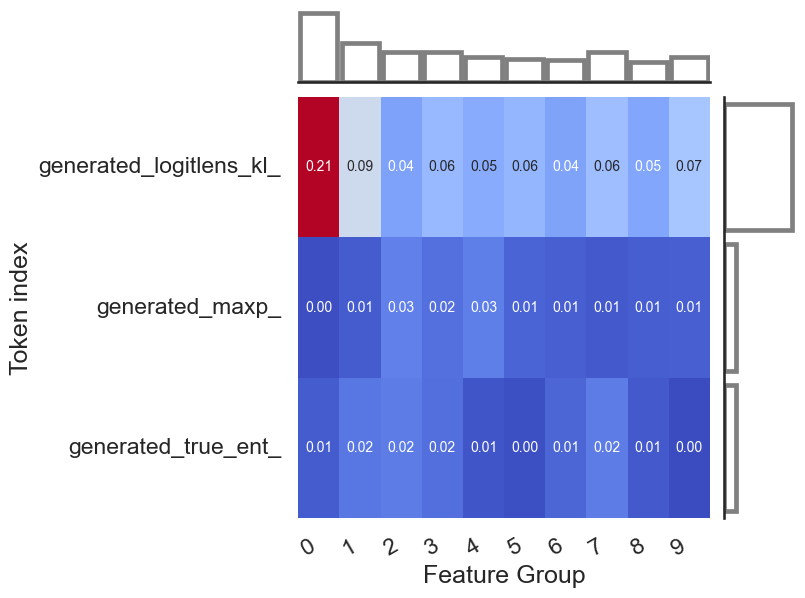

In [156]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### only kl

In [157]:
# beginning of generation
N = 10

# selected_features = ['true_ent', 'maxp'] # + list(df_logitlens_kl_expanded.columns) + list(df_logitlens_iou_expanded.columns)
selected_features = list(df_logitlens_kl_expanded.columns)

#selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'pe_rao_trans_s_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [158]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 1min 41s, sys: 4.39 s, total: 1min 45s
Wall time: 17.4 s


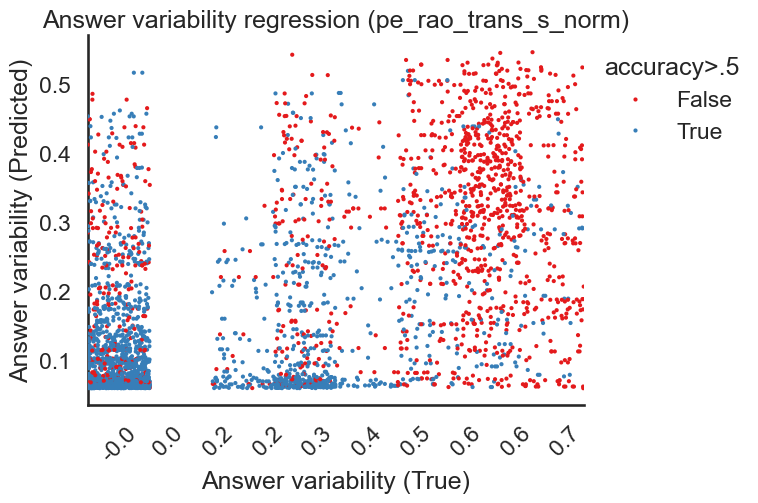

In [159]:
ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=0.5, 
                   hue=correct_mean, 
                   size=3, 
                   palette='Set1') # , log_scale=(True,False))
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [160]:
met = assessme(y_res.values, pred)
met

{'mae': 0.1539193095124822,
 'mse': 0.03860666313978562,
 'rmse': 0.19648578355643348,
 'r2': 0.3373373799925321,
 'adj_r2': 0.3372110382156003}

invalid value encountered in scalar divide


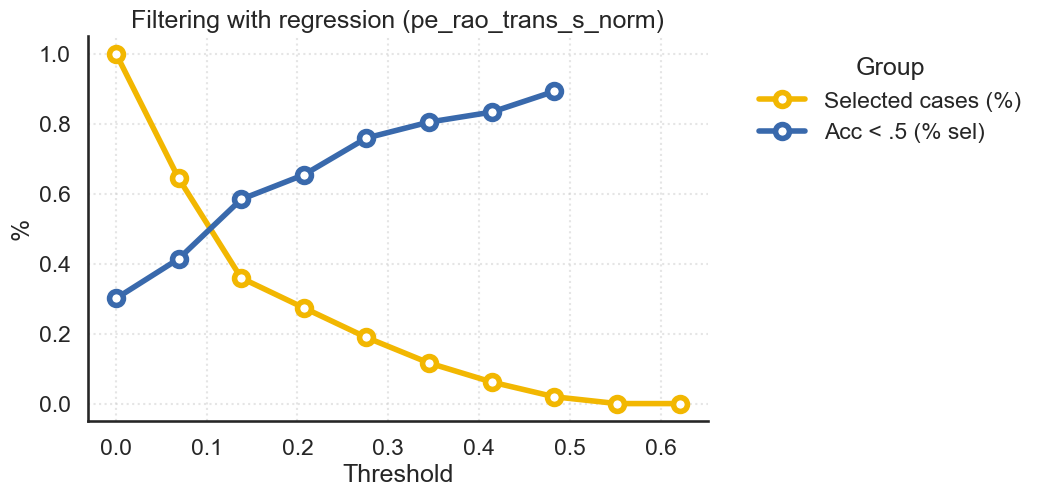

In [161]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean[pred>=thr]).sum() / (pred>=thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

In [162]:
%%time
import xgboost
import shap

# model = xgboost.XGBRegressor(n_estimators=100, booster='gbtree', max_depth=2).fit(X_res, y_res)
model = xgboost.XGBRegressor(n_estimators=100, booster='gblinear').fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 3.6 s, sys: 304 ms, total: 3.91 s
Wall time: 535 ms


In [163]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

# vals.groupby('grp').value.sum()

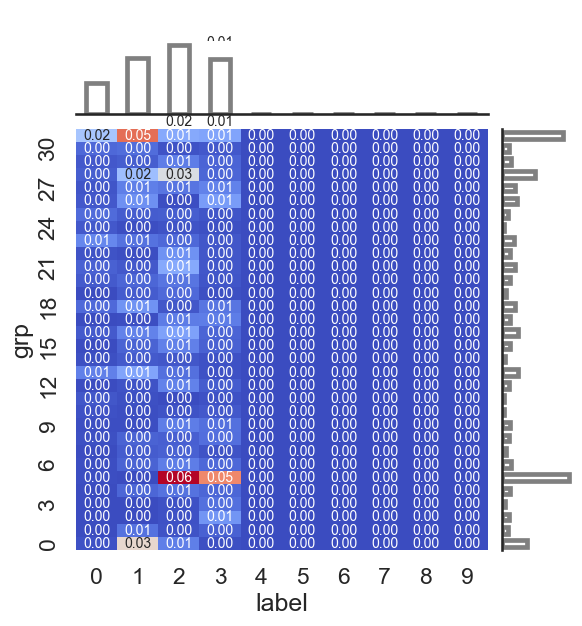

In [164]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 10)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 32)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

In [165]:
# besties
list(vals.sort_values('value', ascending=False)[:10].label_orig)

['generated_logitlens_kl5_2',
 'generated_logitlens_kl31_1',
 'generated_logitlens_kl5_3',
 'generated_logitlens_kl36_0',
 'generated_logitlens_kl0_1',
 'generated_logitlens_kl28_2',
 'generated_logitlens_kl36_3',
 'generated_logitlens_kl36_1',
 'generated_logitlens_kl35_2',
 'generated_logitlens_kl31_0']

In [166]:
%%time

# another booster bits the dust

import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100, booster='gblinear').fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 3.52 s, sys: 564 ms, total: 4.09 s
Wall time: 580 ms


In [167]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

# vals.groupby('grp').value.sum()

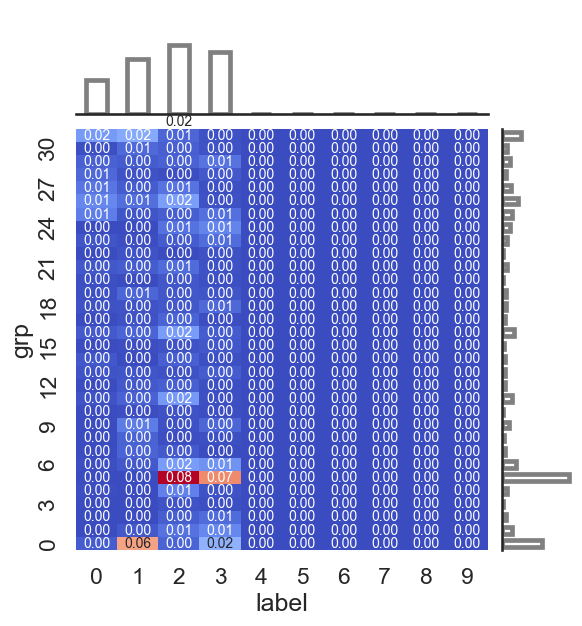

In [168]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 10)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 32)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

### only best kl features with original ones

In [169]:
# beginning of generation
N = 10

selected_features = ['maxp', 'true_ent'] + list(df_logitlens_kl_expanded.columns)


# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'pe_rao_trans_s_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

besties = ['logitlens_kl36_1',
 'logitlens_kl5_2',
 'logitlens_kl28_2',
 'logitlens_kl38_1',
 'logitlens_kl28_0',
 'logitlens_kl37_3',
 'logitlens_kl30_2',
 'logitlens_kl40_2',
 'logitlens_kl6_2',
 'logitlens_kl35_2']

ds = ds[[c for c in ds.columns if c in besties or 'logitlens' not in c]]

y = ds[target].abs().round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [170]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 9.5 s, sys: 1.91 s, total: 11.4 s
Wall time: 1.57 s


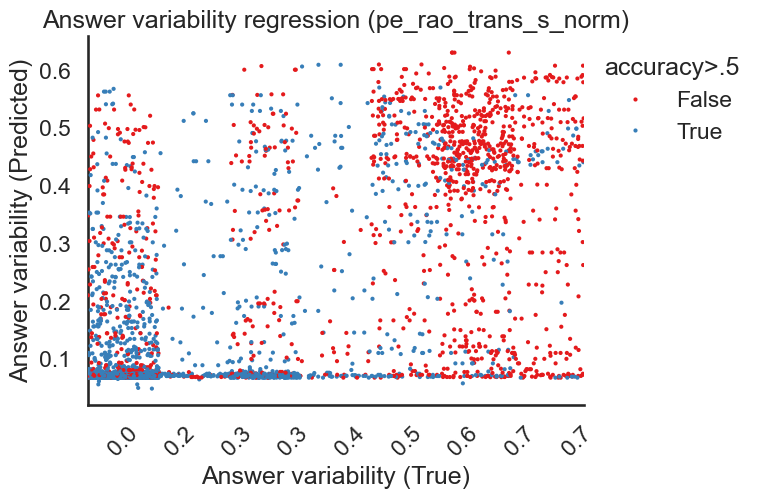

In [171]:
ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=0.5, 
                   hue=correct_mean, 
                   size=3, 
                   palette='Set1') # , log_scale=(True,False))
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [172]:
met = assessme(y_res.values, pred)
met

{'mae': 0.1357914384993935,
 'mse': 0.03304909561535084,
 'rmse': 0.18179410225678622,
 'r2': 0.43273003911139574,
 'adj_r2': 0.43262188468605955}

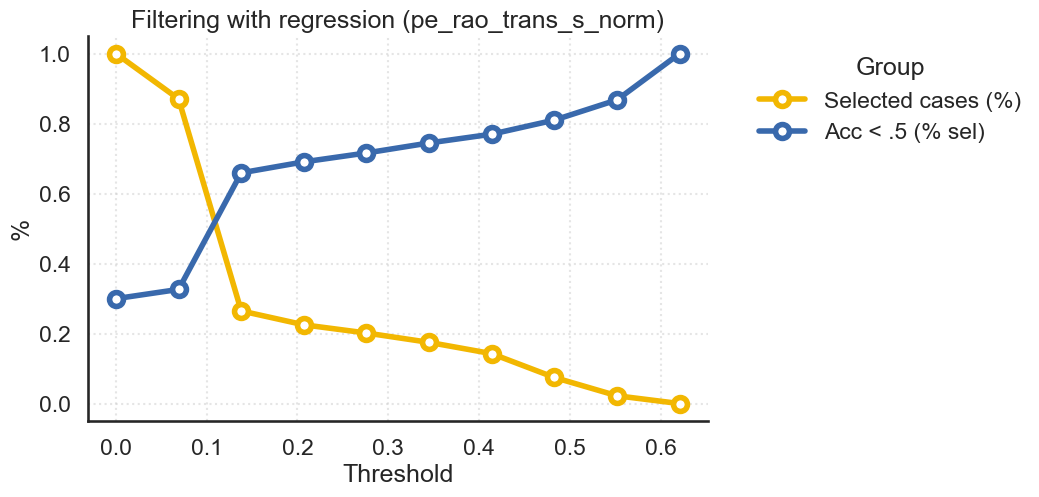

In [173]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean[pred>=thr]).sum() / (pred>=thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

In [174]:
%%time

import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

 91%|==================  | 4793/5247 [00:11<00:01]       

CPU times: user 14.1 s, sys: 463 ms, total: 14.6 s
Wall time: 11.4 s


Text(33.22569444444443, 0.5, 'Token index')

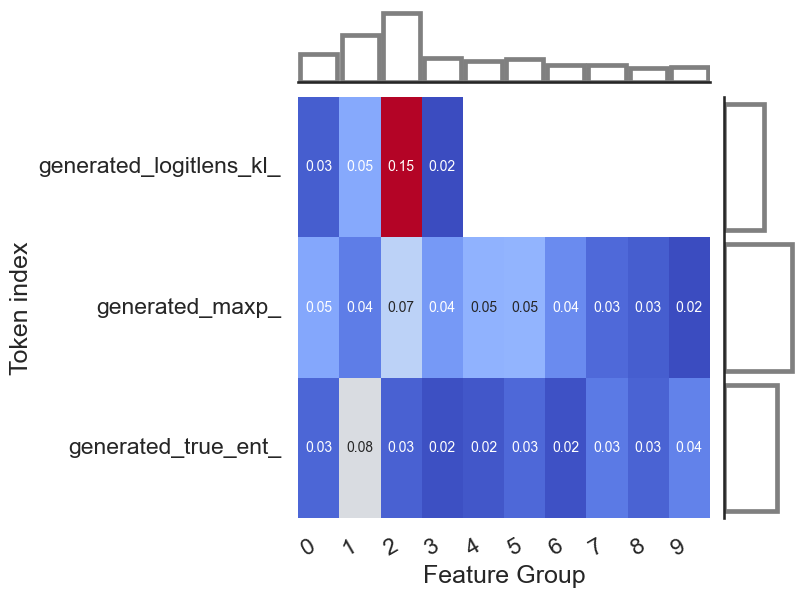

In [175]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

vals.groupby('grp').value.sum()

_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### postilla + kl

In [176]:
# beginning of generation
selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean = ds.correct_mean
correct_mean_thr = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [177]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 39.5 s, sys: 4.54 s, total: 44.1 s
Wall time: 7.86 s


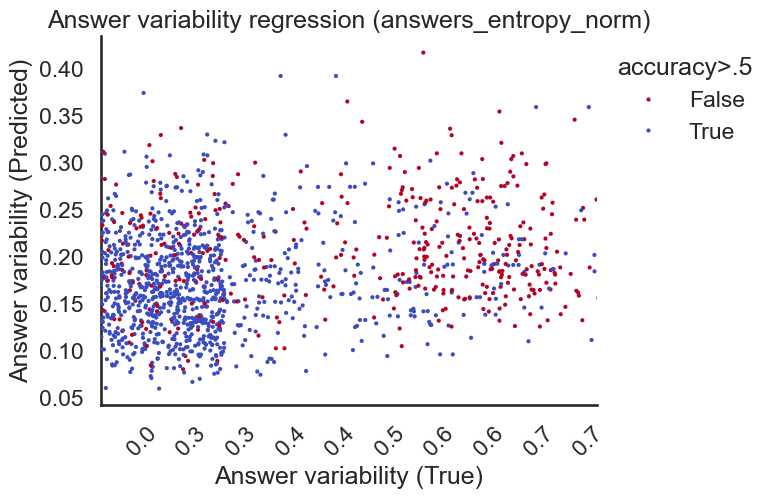

In [178]:
import matplotlib.colors as mcolors

norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=1, 
                   hue=correct_mean_thr, 
                   size=3, 
                   palette = palette)
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [179]:
met = assessme(y_res.values, pred)
met

{'mae': 0.21961610302637427,
 'mse': 0.06068836761155646,
 'rmse': 0.24635009155987025,
 'r2': 0.05682489234276655,
 'adj_r2': 0.05625013603097051}

invalid value encountered in scalar divide


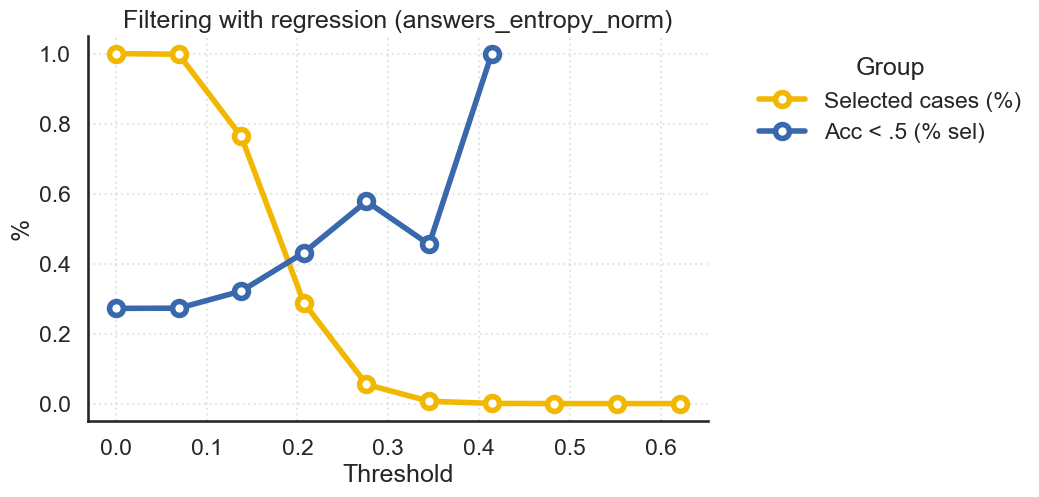

In [180]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred > thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean_thr[pred>thr]).sum() / (pred>thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

### increasing number of cases

In [76]:
ds.pid.nunique()

1470

In [77]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

#X_res, y_res = X, y # rus.fit_resample(X, y)
#pids_res = pids # [y_res.index]

# X_res.columns = ['generated_'+col for col in X.columns]

In [78]:
group_kfold = GroupKFold(n_splits=10)

foldlist = []

for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, pids)):
    foldlist.append(test_index)

In [79]:
# %%time

prog = []

# cycle all
for i, idxs in enumerate(foldlist):
    print(i)
    
    test_idx = idxs
    
    # cycle all, skipping i
    train_idx = set()
    c = 0
    
    # tutti gli id fuorché la fold corrente
    foldlist_ = [idxs_ for (j, idxs_) in enumerate(foldlist) if i != j]
    fold_train_idx = np.concatenate(foldlist_)
    
    # cycle all available pids
    fold_pids = pids.iloc[fold_train_idx]
    
    for pid in tqdm(fold_pids.unique()):
        
        # enlarge dataset one pid at a time
        train_idx = set(train_idx) | set(fold_train_idx[fold_pids == pid]) 
        train_idx = list(train_idx)

        xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)
        xgb_model.fit(X.iloc[train_idx], y.iloc[train_idx])

        pred = xgb_model.predict(X.iloc[test_idx])
        
        # always test on out-of-fold data
        met = assessme(y.iloc[test_idx].values, pred)

        prog.append((i, c, len(train_idx), met['mae'], met['mse'], met['rmse'], met['r2']))
        c += 1
            

0


100%|███████████████████████████████████████| 1323/1323 [02:43<00:00,  8.09it/s]


1


100%|███████████████████████████████████████| 1323/1323 [01:52<00:00, 11.76it/s]


2


100%|███████████████████████████████████████| 1323/1323 [01:44<00:00, 12.67it/s]


3


100%|███████████████████████████████████████| 1323/1323 [01:43<00:00, 12.78it/s]


4


100%|███████████████████████████████████████| 1323/1323 [01:56<00:00, 11.37it/s]


5


100%|███████████████████████████████████████| 1323/1323 [01:51<00:00, 11.85it/s]


6


100%|███████████████████████████████████████| 1323/1323 [02:14<00:00,  9.83it/s]


7


100%|███████████████████████████████████████| 1323/1323 [02:05<00:00, 10.57it/s]


8


100%|███████████████████████████████████████| 1323/1323 [02:54<00:00,  7.58it/s]


9


100%|███████████████████████████████████████| 1323/1323 [03:59<00:00,  5.52it/s]


In [80]:
prog_ = pd.DataFrame(prog, columns=['i', 'c', 'n', 'mae', 'mse', 'rmse', 'r2'])

In [81]:
prog_.shape

(13230, 7)

In [82]:
prog_

,i,c,n,mae,mse,rmse,r2
0,0,0,2,0.247821,0.125319,0.354004,-0.961057
1,0,1,5,0.252773,0.090030,0.300050,-0.408839
2,0,2,9,0.252115,0.088675,0.297784,-0.387643
3,0,3,15,0.253702,0.094765,0.307839,-0.482931
4,0,4,17,0.257394,0.087372,0.295588,-0.367248
...,...,...,...,...,...,...,...
13225,9,1318,2791,0.138779,0.028919,0.170054,0.607871
13226,9,1319,2792,0.137622,0.028764,0.169599,0.609967
13227,9,1320,2793,0.138922,0.029035,0.170396,0.606294
13228,9,1321,2795,0.140019,0.029614,0.172086,0.598444


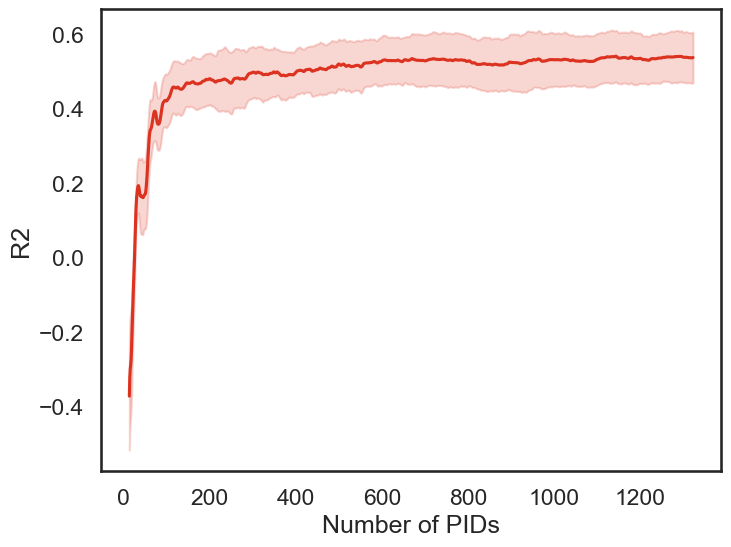

In [83]:
def smooth_data(df, column, window=10):
    return df.groupby("i")[column].transform(lambda x: x.rolling(window, win_type="gaussian").mean(std=2))

prog_["mae_smooth"] = smooth_data(prog_, "mae", window=15)
prog_["r2_smooth"] = smooth_data(prog_, "r2", window=15)

plt.figure(figsize=(8, 6))
sns.lineplot(prog_, x="c", y="r2_smooth", errorbar="sd", color='#DC3220')
# plt.title("Entropy regression MAE over number of PIDs in training")
plt.xlabel("Number of PIDs")
plt.ylabel("R2")
plt.show()

<Axes: xlabel='c', ylabel='mae'>

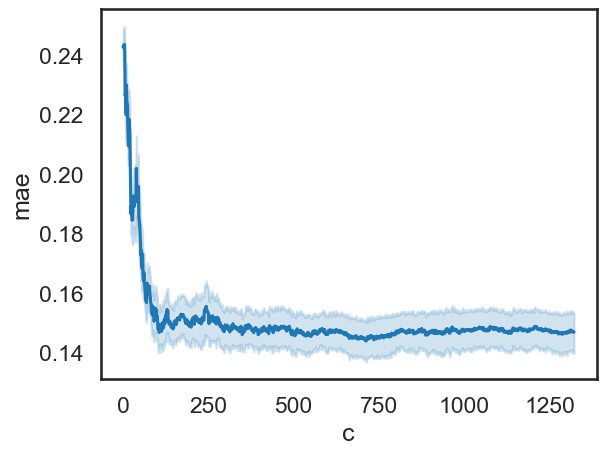

In [84]:
# x = #pids
sns.lineplot(prog_, x='c', y='mae')

<Axes: xlabel='c', ylabel='mae'>

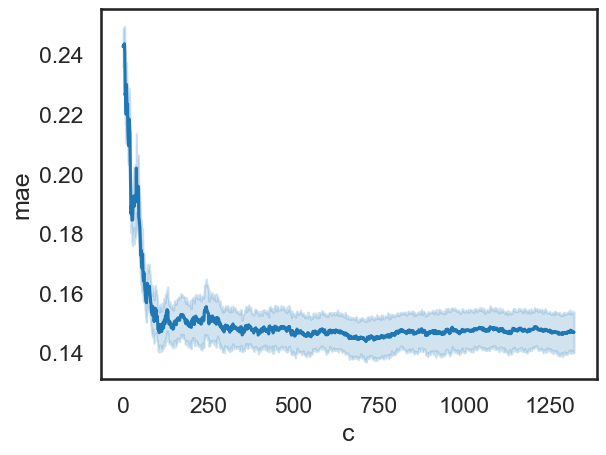

In [85]:
# x = #pids
sns.lineplot(prog_, x='c', y='mae')

### beginning of generation, accuracy

In [86]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

print(ds.shape)

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

print(ds.shape)

y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

X_res.shape

(14700, 24)
(3112, 24)


(3112, 18)

In [87]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred = cross_val_predict(xgb_model, X_res, correct_mean, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 6.1 s, sys: 3.57 s, total: 9.67 s
Wall time: 2.21 s


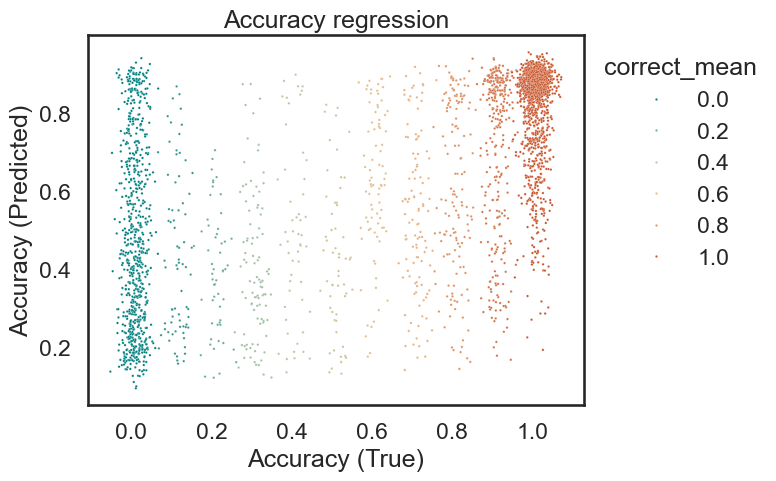

In [88]:
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.diverging import Geyser_4, Temps_6
palette = Geyser_4.get_mpl_colormap()

def jitter(values,j):
    return values + np.random.normal(j,0.02, values.shape)

ax = sns.scatterplot(y=jitter(pred,0.01), x=jitter(correct_mean.values, 0.01), hue=correct_mean, s=3, palette=palette)

plt.title('Accuracy regression')
plt.xlabel('Accuracy (True)')
plt.ylabel('Accuracy (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [89]:
(correct_mean.values==1.).sum()

1389

In [90]:
met = assessme(correct_mean.values, pred)
met

{'mae': 0.2603760227900966,
 'mse': 0.11000338944336543,
 'rmse': 0.33166758877431096,
 'r2': 0.3833668518536748,
 'adj_r2': 0.38316857752951194}

In [91]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, correct_mean)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [92]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [93]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.484248
generated_true_ent_    0.515752
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

The palette list has more values (10) than needed (9), which may not be intended.


<Axes: xlabel='label', ylabel='value'>

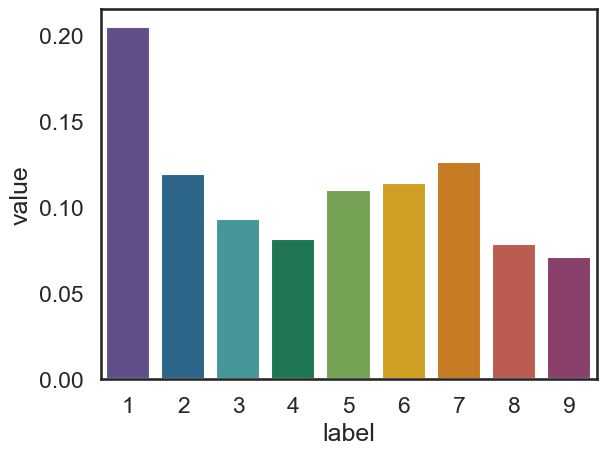

In [94]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

### postilla

In [95]:
selected_features

['true_ent', 'maxp']

In [96]:
# all postilla

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

print(ds.shape)

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

print(ds.shape)

y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['postilla_'+col for col in X.columns]

X_res.shape

(14700, 126)
(1645, 126)


(1645, 120)

In [97]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred_postilla = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 15.7 s, sys: 5.74 s, total: 21.4 s
Wall time: 4.74 s


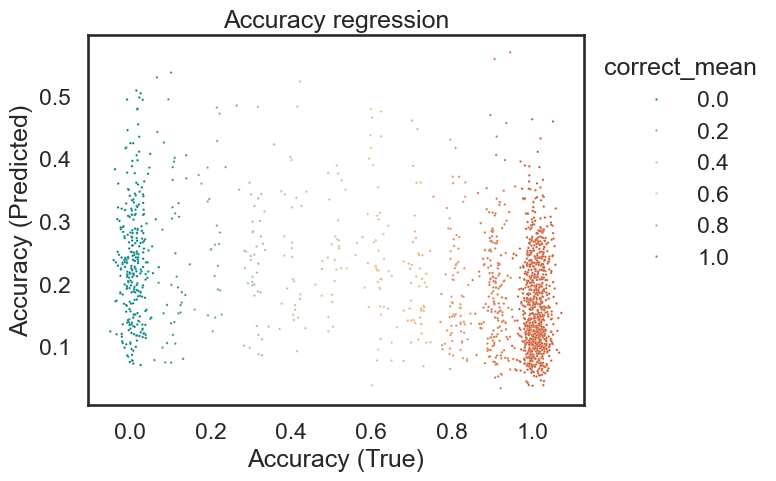

In [98]:
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.diverging import Geyser_4, Temps_6
palette = Geyser_4.get_mpl_colormap()

def jitter(values,j):
    return values + np.random.normal(j,0.02, values.shape)

ax = sns.scatterplot(y=jitter(pred_postilla,0.01), x=jitter(correct_mean.values, 0.01), hue=correct_mean, s=3, palette=palette)

plt.title('Accuracy regression')
plt.xlabel('Accuracy (True)')
plt.ylabel('Accuracy (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [99]:
(correct_mean.values==1.).sum()

845

In [100]:
met = assessme(correct_mean.values, pred_postilla)
met

{'mae': 0.6185812486404706,
 'mse': 0.4682234080005871,
 'rmse': 0.6842685203928258,
 'r2': -2.0056866589511637,
 'adj_r2': -2.0075160482749324}

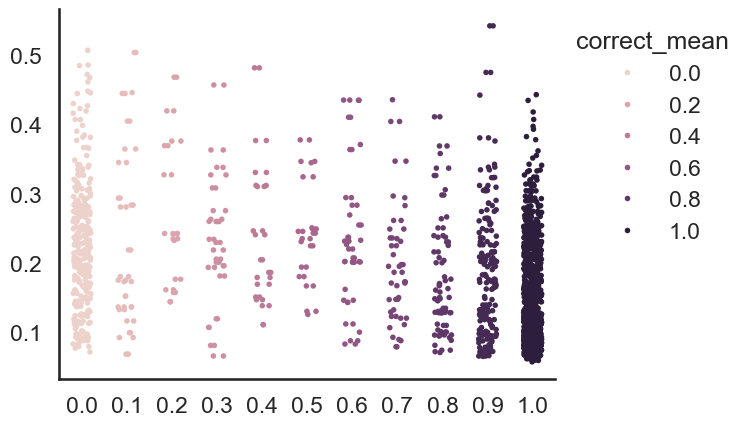

In [101]:
ax = sns.stripplot(y=pred_postilla, x=np.round(correct_mean.values,2), jitter=0.2, hue=correct_mean, size=4) # , log_scale=(True,False))
sns.despine()

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

### postilla + logitlens

In [102]:
# all postilla + kl

selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

print(ds.shape)

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

print(ds.shape)

y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['postilla_'+col for col in X.columns]

X_res.shape

(14700, 2586)
(4491, 2586)


(4491, 2580)

In [103]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred_postilla = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 4min 19s, sys: 52 s, total: 5min 11s
Wall time: 1min 8s


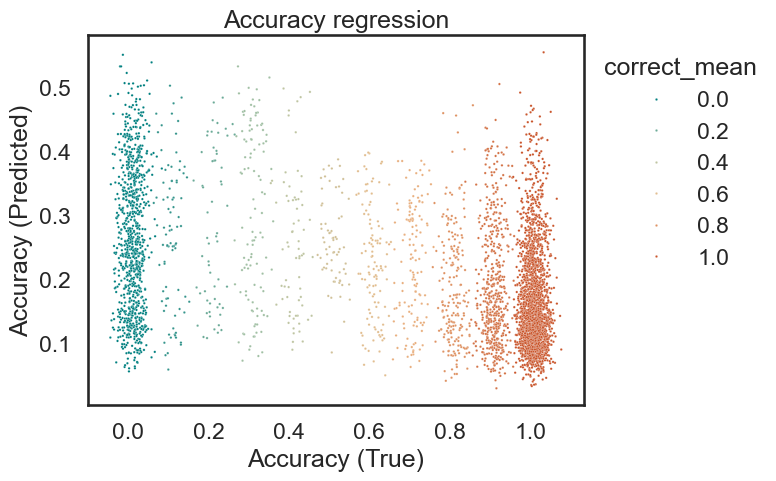

In [104]:
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.diverging import Geyser_4, Temps_6
palette = Geyser_4.get_mpl_colormap()

def jitter(values,j):
    return values + np.random.normal(j,0.02, values.shape)

ax = sns.scatterplot(y=jitter(pred_postilla,0.01), x=jitter(correct_mean.values, 0.01), hue=correct_mean, s=3, palette=palette)

plt.title('Accuracy regression')
plt.xlabel('Accuracy (True)')
plt.ylabel('Accuracy (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [105]:
met = assessme(correct_mean.values, pred_postilla)
met

{'mae': 0.6199811117392199,
 'mse': 0.4658288320258043,
 'rmse': 0.6825165434081465,
 'r2': -1.8125930660048004,
 'adj_r2': -1.81321961825831}